# Clasificador de dífitos manuscritos
En este ejercicio utilizaremos `giotto-tda` para realizar un análisis topológico de datos sobre el conjunto de datos MNIST, con la finalidad de entrenar un algortimo clasificador. Este ejemplo está basado en el clasificador de dígitos manuscritos de que se encuentra en la página oficial de [Giotto-tda](https://giotto-ai.github.io/gtda-docs/latest/notebooks/MNIST_classification.html).

## Carga de los datos MNIST
Comenzamos cargando el conjunto de datos MNIST utilizando la función `fetch_openml` del módulo `sklearn.datasets`. Observemos que el conjunto cuenta con 70,000 imágenes de 784 pixeles cada una.

In [28]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml("mnist_784", version=1, return_X_y=True)

print(f'X shape:{X.shape}, y shape:{y.shape}')

X shape:(70000, 784), y shape:(70000,)


Dado que las imágenes han sido "aplanadas" en un arreglo unidimensional, redimensionaremos el arreglo en un vector de $28\times 28$ y visualizaremos algunos de los dígitos mediante la función `plot_heatmap` de `gtda.plotting`. A continuación se muestran algunas de las imágenes del conjunto de datos:

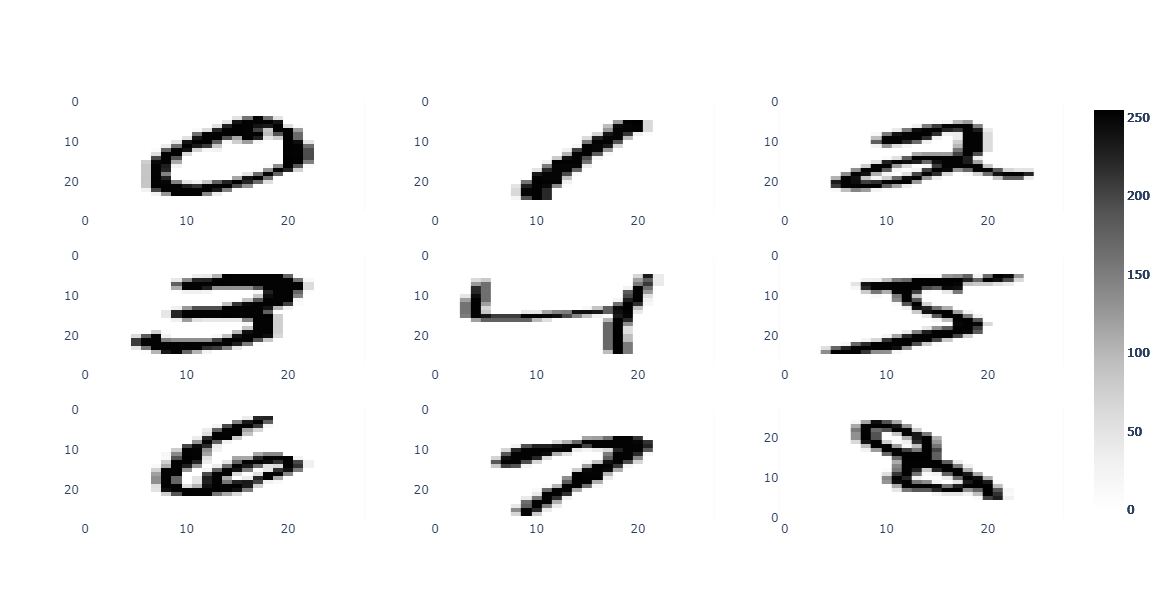

In [30]:
import numpy as np
from gtda.plotting import plot_heatmap
from plotly.subplots import make_subplots

digits_idx = [np.flatnonzero(y == chr(digit))[0] for digit in range(ord('0'), ord('9'))]
digits = [np.asarray(X.iloc[digit_idx]).reshape(28, 28) for digit_idx in digits_idx]
digit_plots = [plot_heatmap(digit) for digit in digits]

fig = make_subplots(3, 3)
fig.update_layout(width=800, height=600)

i = 0
for row in range(1, 4):
    for col in range(1, 4):
        if i != 0:
            fig['layout']['yaxis' + str(i)]['autorange'] = 'reversed'
        else:
            fig['layout']['yaxis']['autorange'] = 'reversed'
            
        fig.add_trace(digit_plots[i]['data'][0], row=row, col=col)
        i += 1

fig.show()

## Separamos el conjunto de datos
Para este ejemplo trabajaremos con un subconjunto de datos, de igual forma que en el ejercicio original de Giotto-tda. En este caso consideraremos una muestra de 70 elementos, donde separaremos dicho subconjunto en datos de entrenamiento y validación con una relación 85-15, es decir, 60 datos de entrenamiento y 10 de validación.

In [32]:
from sklearn.model_selection import train_test_split

train_size, test_size = 60, 10

X = np.asarray(X).reshape((-1, 28, 28))
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=test_size, stratify=y, random_state=666)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (60, 28, 28), y_train shape: (60,)
X_test shape: (10, 28, 28), y_test shape: (10,)


## Características topológicas
A diferencia del cálculo de las características topológicas de un conjunto de datos como el visto en el notebook de figuras 3D, encontrar características topológicas en una imagen no es un procedimiento tan directo. Dado que una imagen generalmente está representada por píxeles, es conveniente utilizar complejos cúbicos en ligar de complejos simpliciales. Como ejemplo del procedimiento a seguir, realizaremos el mismo sobre un único dígito, a saber, el 8.

In [34]:
im8_idx = np.flatnonzero(y_train == '8')[0]

# En este caso necesitamos el formato (n_samples, n_pixels_x, n_pixels_y)
im8 = X_train[im8_idx][None, :, :]

### Binarizado de la imagen
Las filtraciones mediante complejos cúbicos en `giotto-tda` se aplican únicamente a *imágenes binarias*, las cuales consisten en solo píxeles en blanco y negro. Podemos convertir imágenes en escala de grises a imágenes binarias mediante la función `Binarizer` del módulo `gtda.images`, considerando un umbral adecuado en cada píxel.

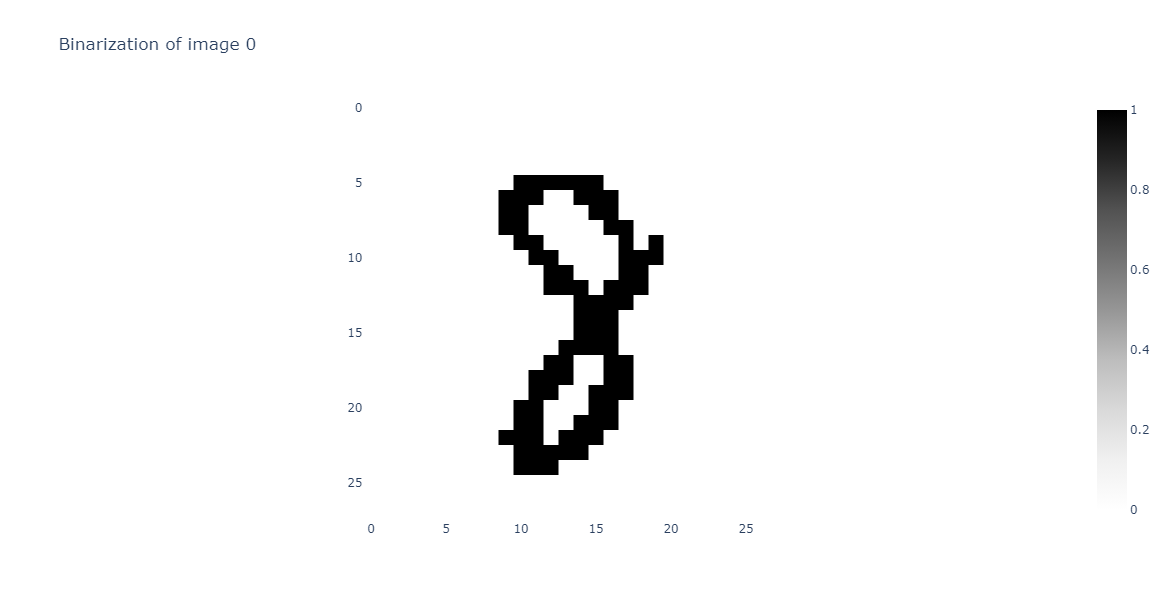

In [36]:
from gtda.images import Binarizer

# El umbral elegido en este caso es de 0.4
binarizer = Binarizer(threshold=0.4)
im8_binarized = binarizer.fit_transform(im8)

binarizer.plot(im8_binarized, 
               plotly_params={'layout':{'width':800, 'height':600}})

### Filtrado de la imagen
Ahora que hemos binarizado nuestra imagen $\mathcal B$, podemos comenzar con el filtrado de la misma, podemos encontrar las distintas técnicas de filtrado disponibles en `giotto-tda` en la [documentación](https://giotto-ai.github.io/gtda-docs/latest/modules/images.html#filtrations) oficial. Para este ejemplo utilizaremos el *filtrado radial* $\mathcal R$, el cual consiste en asignar a cada píxel $p$ su distancia al "centro" $c$ de la imagen, de tal forma que
$$
\mathcal R(p)=
\begin{cases}
\|c-p\|_2          &\text{si}\quad\mathcal B(p)=1\\
\mathcal R_\infty  &\text{si}\quad\mathcal B(p)=0
\end{cases}
$$
donde $\mathcal R_\infty$ es la distancia del píxel más alejado de $c$. Con la finalidad de reproducir el filtrado realizado en el [artículo](https://arxiv.org/abs/1910.08345) de MNIST, consideramos $c=(20,6)$. Para realizar el filtrado radial utilizaremos la función `RadialFiltration` de `gtda.images`.

Podemos interpretar el gráfico resultante como:
* Azul: Cercano a $c$.
* Rojo. Lejano a $c$.

De esta forma, hemos regresado el gráfico a una escala de grises, pero esta vez la escala tiene una interpretación geométrica clara. Los valores de estos píxeles pueden utilizarse para crear una filtración mediante complejos cúbicos $\{K_i\}_{i\in\text{Im}(I)}$, donde $K_i$ contiene a los píxeles con valores menores al $i$-ésimo valor más pequeño en términos de intensidad en la escala de grises.

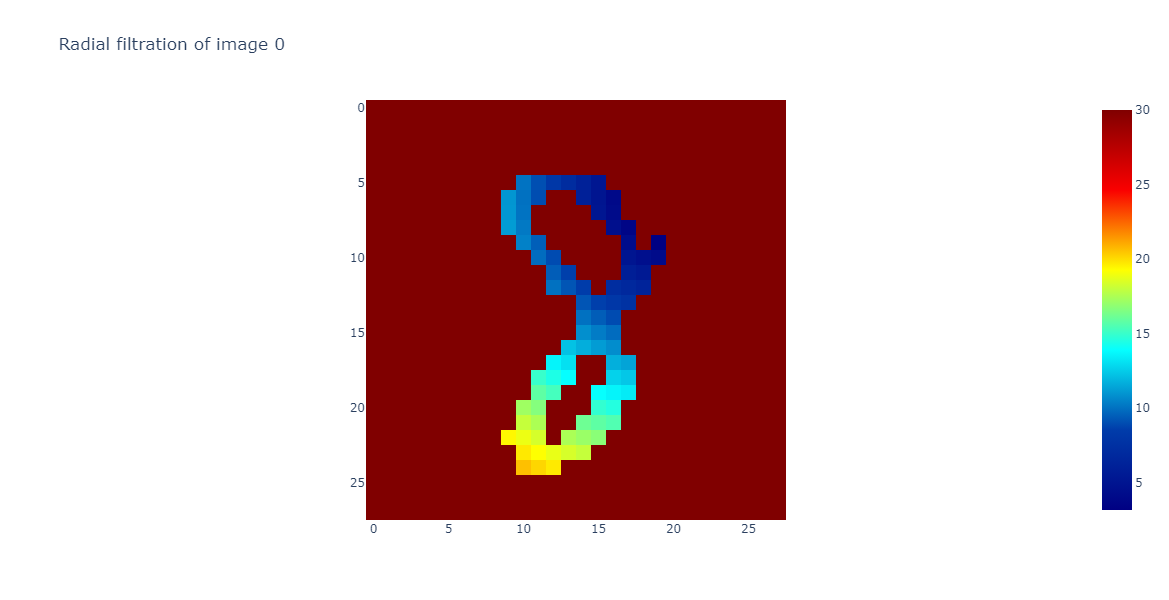

In [46]:
from gtda.images import RadialFiltration

# RadialFiltration toma como argumento un centro de tipo array
radial_filtration = RadialFiltration(center=np.array([20, 6]))
im8_filtration = radial_filtration.fit_transform(im8_binarized)

radial_filtration.plot(im8_filtration, colorscale='jet',
                      plotly_params={'layout':{'width':800, 'height':600}})

## Diagrama de persistencia
Como se ha mencionado anteriormente, esta filtración se realizará mediante complejos cúbicos, para lo cual utilizaremos la función `CubicalPersistence` del módulo `gtda.homology`. En el gráfico de persistencia (idealmente) no deberíamos observar a cerca de
* H_0: un único punto.
* H_1: dos puntos notablemente alejados de la diagonal.

En este caso queda claro que el gráfico de persistencia real se aemeja bastante al esperado.

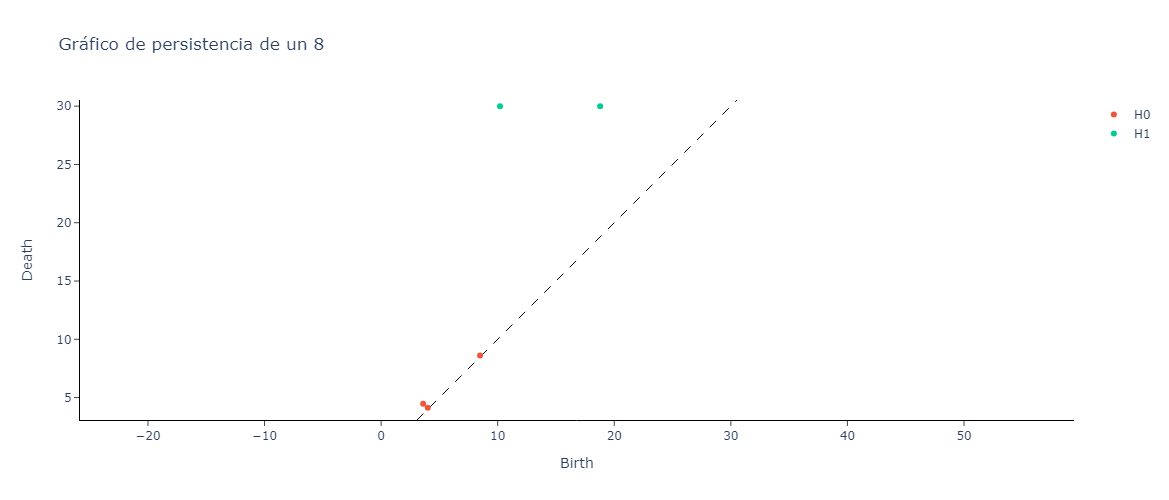

In [58]:
from gtda.homology import CubicalPersistence

cubical_persistence = CubicalPersistence()
im8_cubical = cubical_persistence.fit_transform(im8_filtration)

cubical_persistence.plot(im8_cubical, 
                         plotly_params={'layout':{'title':'Gráfico de persistencia de un 8'}})

Un punto a destacar es la escala del diagrama anterior, el cual va de 0 a 30 en ambos ejes. Resulta conveniente reescalar los diagramas, tarea que puede ser realizada por la función `Scaler` del módulo `gtda.diagrams`.

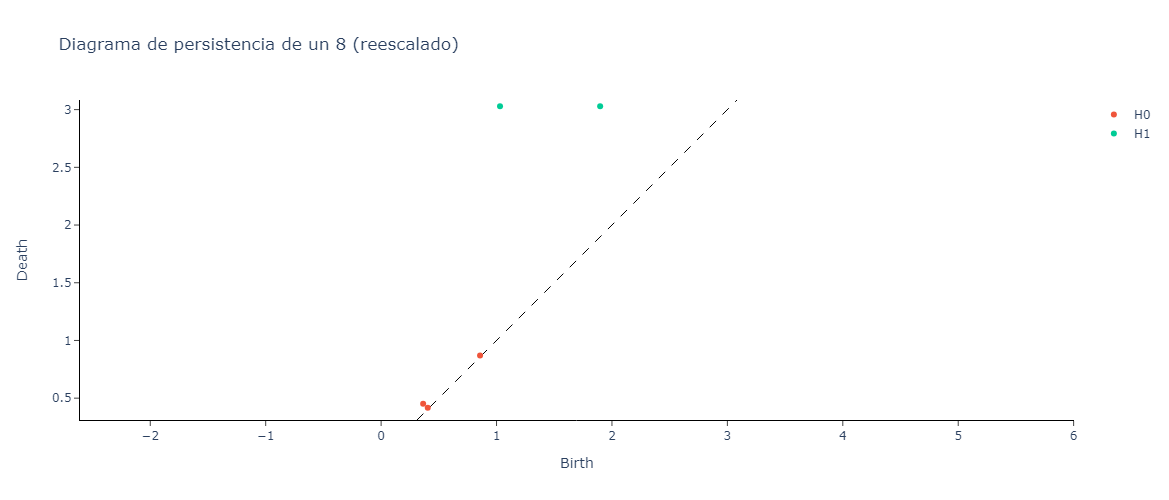

In [67]:
from gtda.diagrams import Scaler

scaler = Scaler()
im8_scaled = scaler.fit_transform(im8_cubical)

scaler.plot(im8_scaled, 
            plotly_params={'layout':{'title':'Diagrama de persistencia de un 8 (reescalado)'}})

## Kernel gaussiano
Una vez hemos obtenido el diagrama de persistencia deseado, es momento de vectorizar el mismo para extraer la información conveniente. En este caso utlizaremos un método de kernel gaussianos para realizar dicha vectorización. La técnica de kernel gaussiano (al igual que otras técnicas de kernel) consiste en aplicar convoluciones a nuestro diagrama de persistencia, y simetrizar a lo largo de la diagonal. El proceso anteriormente descrito puede ser realizado mediante la función `HeatKernel` del módulo `gtda.diagrams`, la cual requiere especificar los parámetros
* sigma(`float`, 0.1 por defecto): La desciación estándar del kernel gaussiano.
* n_bins(`int`, 100 por defecto): El número de valores de parámetros de filtración para muestrear durante el ajuste del modelo.

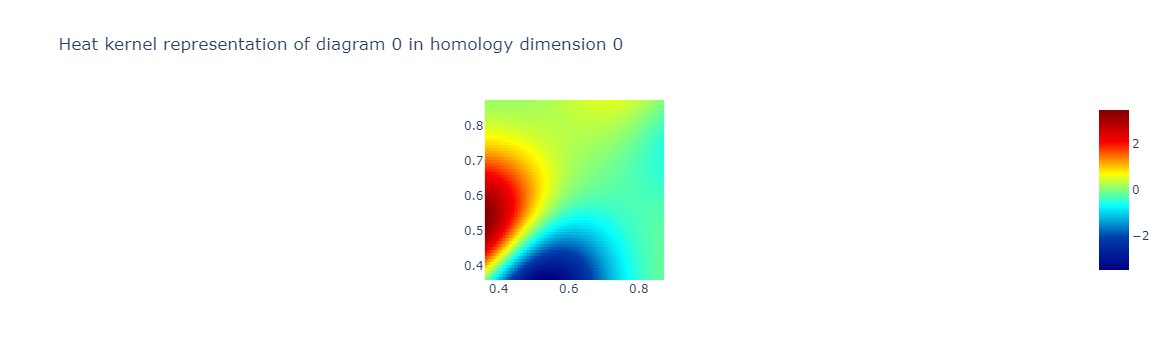

In [75]:
from gtda.diagrams import HeatKernel

heat = HeatKernel(sigma=0.15, n_bins=60)
im8_heat = heat.fit_transform(im8_scaled)

heat.plot(im8_heat, homology_dimension_idx=0, colorscale='jet')

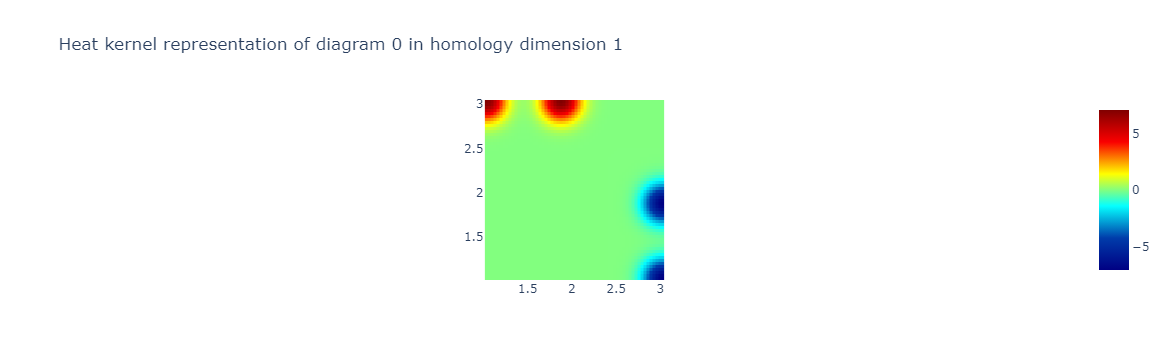

In [77]:
heat.plot(im8_heat, homology_dimension_idx=1, colorscale='jet')

## Pipeline
Ahora que tenemos desarrollada una metodología para extraer las características topológicas deseadas, podemos diseñar el pipeline para analizar el conjunto de datos previamente definidos. Comenzaremos creando el pipeline basado en el ejemplo anterior, para posteriormente generalizarlo más tarde.

In [87]:
from sklearn.pipeline import Pipeline
from gtda.diagrams import Amplitude

steps = [
    ('binarizer', Binarizer(threshold=0.4)),
    ('filtration', RadialFiltration(center=np.array([20, 6]))),
    ('diagram', CubicalPersistence()),
    ('rescaling', Scaler()),
    ('amplitude', Amplitude(metric='heat', metric_params={'sigma':0.15, 'n_bins':60}))
]

heat_pipline = Pipeline(steps)
im8_pipeline = heat_pipline.fit_transform(im8)
im8_pipeline

array([[0.57234335, 2.49781365]])

## Procesando el conjunto de datos.